# State space

First, we need to define the Input space $\mathcal{X}$ dimension along with how many categories each feature variable can take.

Given $d$ feature variables $\{X_i\}_{0 \le i \le d-1}$ such that $\forall{i\in \{1, \ldots, d\}}: X_i \in \{0, \ldots, k_i -1 \}$. The state space is of size:
$$|\mathcal{S}| = \prod_{i=0}^{d-1} \left( 1 + k_i\right)$$
At first we would like to work in a tabular Reinforcement learning framework (point-wise estimation of the Q function instead of an approximation), so we need the state space to be relatively small. That said, we will work with the three following examples:

- $d = 6$; $k_0 = 4, k_1 = 3, k_2 = 3, k_3 = 3, k_4 = 2, k_5 = 4$: $|\mathcal{S}| = 4800$
- $d = 6$; $k_0 = 4, k_1 = 3, k_2 = 4, k_3 = 3, k_4 = 4, k_5 = 4$: $|\mathcal{S}| = 10000$
- $d = 6$; $k_0 = 6, k_1 = 5, k_2 = 6, k_3 = 5, k_4 = 6, k_5 = 6$: $|\mathcal{S}| = 86436$

In each case, feature variables are considered independent and uniform on their respective supports, and a generator will generate data points successively in order to be fed to the RL algorithm.

# Concept

We will work in a binary classification framework and consisder a fairly simple true labeling concept that might give rise to an interesting behaviour of the RL agent. For the first two experiments the concept maps a data point $x = \left(x_0, \ldots, x_{d-1}\right)$ to $1$ if $\forall{i \in \{0, \ldots, d-1\}}: x_i \le 2$, otherwise, it maps it to $0$, for the last experiment the condition is $x_i \le 4$

Given that some feature variables never exceed $2$, an optimal behaviour should completely dismiss these features in its decision making process. We will see if it is the case of our agent in both considered examples.

# Reward

We consider the reward function used in the RLDT paper.

- $R_+ = 5$, the reward of reporting the right label.
- $R_- = -5$, the reward of reporting the wrong label.
- $R_i = -C_i = -1$, the reward of querying the $i^{th}$ feature.

# Q-Learning

We use tabular Q-Learning. Here is a brief explanation of the algorithm:

- Initialize the values $\mathcal{Q}\left( s, a\right) = 0$ for all possible state action pairs.
- An episode starts with the environment generating a data point, the agent then receives the empty state.
- At a current state $s_t$ the agent takes an action $a_t$ according to an exploratory policy and receives reward $r_t$ and a next state $s_{t+1}$.
- Compute the temporal difference $\delta_t = r_t + \gamma\textrm{max}_a \mathcal{Q}\left( s_{t+1}, a\right) - \mathcal{Q}\left(s_t, a_t \right)$
- Update: $$\mathcal{Q}\left( s_t, a_t\right) = \mathcal{Q}\left( s_t, a_t\right) + \frac{1}{\textrm{visits}\left(s_t, a_t \right)}\delta_t$$
- Return the greedy policy at the end: $$\pi\left(s \right) = \textrm{argmax}_a \mathcal{Q}\left( s, a\right)$$

An episode ends with the agent taking a report action, so we can actually explore the state-action pairs better if we considered query actions throughout an episode to update their corresponding Q-values and then evaluate the report actions on this path. Formally, let us take only query actions from the empty state until completely observing the data point, and let $\left( s_0, \ldots, s_d\right)$ denote this path in terms of the visited states; then we can update $\mathcal{Q}\left( s_0, a\right), \ldots, \mathcal{Q}\left( s_d, a\right)$ for each report action $a$.

In [44]:
from env import *
from agent import *
import matplotlib.pyplot as plt
import re
%matplotlib inline

iteration = lambda s : int(re.split('_', s[:-4])[-1])

## Experiment 1

In [45]:
categories=[4, 3, 3, 3, 2, 4]
labels = [0, 1]

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -1) for i in range(len(categories))])

In [46]:
env = EnvironmentSynthetic(generator=generator, rewards_queries=rewards_queries, encoder=None)
agent = QLearning(categories=categories, min_queries=1)

Check if the classes are balanced on 10000 generated samples.

In [4]:
l = []
for i in range(10000):
    data_point, _ = env.generate()
    l.append(env.concept(data_point))

print('Fraction of 1 labeled points : %.2f' %(np.sum(l)/10000))

Fraction of 1 labeled points : 0.56


Run Q-Learning on 10000 episodes.

In [5]:
n_episodes = int(1e4) + 1
agent.train(env, n_episodes, path_save='q_learning_1/', decay_rate=3e-5, n_save=1000)

Episode : 0 , epsilon : 1.000


/home/otmane/phd/new hope/5f59f212e92012000101e75f/code/agent.py:399: RuntimeWarning: divide by zero encountered in double_scalars
  self.PI[state_repr][action] = 1/(1/self.PI[state_repr][action] + 1) # Update the exploration probability for this action


Episode : 1000 , epsilon : 0.894
Episode : 2000 , epsilon : 0.792
Episode : 3000 , epsilon : 0.694
Episode : 4000 , epsilon : 0.600
Episode : 5000 , epsilon : 0.511
Episode : 6000 , epsilon : 0.430
Episode : 7000 , epsilon : 0.355
Episode : 8000 , epsilon : 0.287
Episode : 9000 , epsilon : 0.227
Episode : 10000 , epsilon : 0.179


Take the greedy policy.

In [6]:
agent.greedy_policy()

Now, let's test the agent on 10000 new generated points and evaluate its accuracy.

In [7]:
print("accuracy=%.2f" %(agent.test(env, 10000)))

accuracy=1.00


The agent gets a $100\%$ accuracy, however, we can think that it has just seen all possible values of the input variable since the state space is not huge and stored their labels, in which case the solution would be of no interest. So, let's check the actual decisin tree learned by the algorithm and verify if it is minimal regarding our concept in the sense that it uses the fewest amount of features possible.

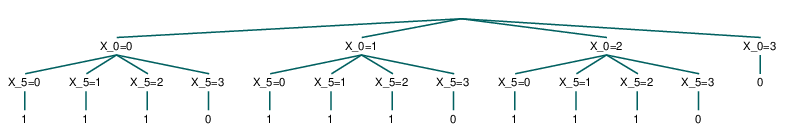

In [8]:
agent.plot_tree()

Only $X_0$ and $X_5$ can have values higher than $2$ and thus are relevant to the decision making process; and indeed we notice that the agent only relied on them and converged to our true concept with as few number of features as possible.

Let's take a look at the evolution of the agent's accuracy during training.

In [47]:
accuracies = []
iterations = []
list_weights = sorted(os.listdir('q_learning_1/'), key = iteration)

In [48]:
for i, path in enumerate(list_weights):
    agent.load_weights('q_learning_1/' + path)
    agent.greedy_policy()
    accuracies.append(agent.test(env, n_test=1000))
    iterations.append(iteration(path))

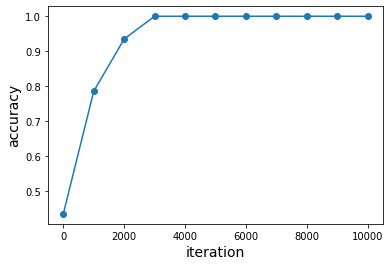

In [49]:
plt.plot(iterations, accuracies, 'o-')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
# plt.savefig('../fig/q_learning_1.png')
plt.show()

In the next experiment, we will test the agent on a bigger state space ($|\mathcal{S}| = 10000$) and see if it is still successful at retrieving the optimal solution with the fewest number of features possible.

## Experiment 2

In [12]:
categories=[4, 3, 4, 3, 4, 4]
labels = [0, 1]

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])
    
# Each query action costs -1
rewards_queries = dict([(i, -1) for i in range(len(categories))])

In [13]:
env = EnvironmentSynthetic(generator=generator, rewards_queries=rewards_queries, encoder=None)
agent = QLearning(categories=categories, min_queries=1)

Check if the classes are balanced on 10000 generated samples.

In [14]:
l = []
for i in range(10000):
    data_point, _ = env.generate()
    l.append(env.concept(data_point))

print('Fraction of 1 labeled points : %.2f' %(np.sum(l)/10000))

Fraction of 1 labeled points : 0.31


Run Q-Learning on 300000 episodes.

In [15]:
n_episodes = int(1e5) + 1
agent.train(env, n_episodes, path_save='q_learning_2/', decay_rate=1e-9)

Episode : 0 , epsilon : 1.000
Episode : 1000 , epsilon : 1.000
Episode : 2000 , epsilon : 1.000
Episode : 3000 , epsilon : 1.000
Episode : 4000 , epsilon : 1.000
Episode : 5000 , epsilon : 1.000
Episode : 6000 , epsilon : 1.000
Episode : 7000 , epsilon : 1.000


/home/otmane/phd/new hope/5f59f212e92012000101e75f/code/agent.py:399: RuntimeWarning: divide by zero encountered in double_scalars
  self.PI[state_repr][action] = 1/(1/self.PI[state_repr][action] + 1) # Update the exploration probability for this action


Episode : 8000 , epsilon : 1.000
Episode : 9000 , epsilon : 1.000
Episode : 10000 , epsilon : 1.000
Episode : 11000 , epsilon : 1.000
Episode : 12000 , epsilon : 1.000
Episode : 13000 , epsilon : 1.000
Episode : 14000 , epsilon : 1.000
Episode : 15000 , epsilon : 1.000
Episode : 16000 , epsilon : 1.000
Episode : 17000 , epsilon : 1.000
Episode : 18000 , epsilon : 1.000
Episode : 19000 , epsilon : 1.000
Episode : 20000 , epsilon : 1.000
Episode : 21000 , epsilon : 1.000
Episode : 22000 , epsilon : 1.000
Episode : 23000 , epsilon : 1.000
Episode : 24000 , epsilon : 1.000
Episode : 25000 , epsilon : 1.000
Episode : 26000 , epsilon : 1.000
Episode : 27000 , epsilon : 1.000
Episode : 28000 , epsilon : 1.000
Episode : 29000 , epsilon : 1.000
Episode : 30000 , epsilon : 1.000
Episode : 31000 , epsilon : 1.000
Episode : 32000 , epsilon : 1.000
Episode : 33000 , epsilon : 1.000
Episode : 34000 , epsilon : 1.000
Episode : 35000 , epsilon : 1.000
Episode : 36000 , epsilon : 1.000
Episode : 37000 

Take the greedy policy.

In [16]:
agent.greedy_policy()

Now, let's test the agent on 10000 new generated points and evaluate its accuracy.

In [17]:
print("accuracy=%.2f" %(agent.test(env, 10000)))

accuracy=0.99


Now,  let's plot the decision tree of our agent. The tree plot is normally unclear, but it becomes clear by double clicking on it.

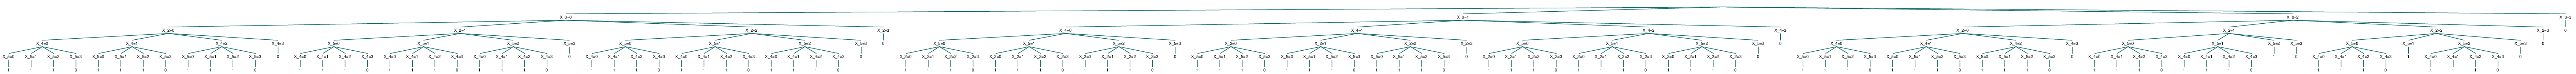

In [18]:
agent.plot_tree()

Indeed we see that the agent only uses feature variables $X_0, X_2, X_4, X_5$, the only features that can have values higher than $2$. The algorithm converged to the optimal minimal tree.

Now let's look at the evolution of the agent's accuracy during training.

In [50]:
accuracies_2 = []
iterations_2 = []
list_weights = sorted(os.listdir('q_learning_2/'), key = iteration)

In [51]:
for i, path in enumerate(list_weights):
    agent.load_weights('q_learning_2/' + path)
    agent.greedy_policy()
    accuracies_2.append(agent.test(env, n_test=1000))
    iterations_2.append(iteration(path))

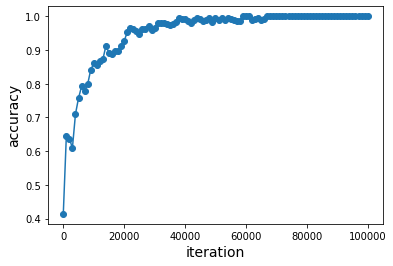

In [52]:
plt.plot(iterations_2, accuracies_2, 'o-')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
# plt.savefig('../fig/q_learning_2.png')
plt.show()

## Experiment 3

In [46]:
categories = [6, 5, 6, 5, 6, 6]
labels = [0, 1]

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])
    
# Each query action costs -1
rewards_queries = dict([(i, -1) for i in range(len(categories))])

In [47]:
env = EnvironmentSynthetic(generator=generator, rewards_queries=rewards_queries, split=5)
agent = QLearning(categories=categories, min_queries=1)

Check if the classes are balanced on 10000 generated samples.

In [4]:
l = []
for i in range(10000):
    data_point = env.generate()
    l.append(env.concept(data_point))

print('Fraction of 1 labeled points : %.2f' %(np.sum(l)/10000))

Fraction of 1 labeled points : 0.48


Run Q-Learning on 5000000 episodes. It takes a longer time here.

In [48]:
n_episodes = int(1e6) + 1
agent.train(env, n_episodes, path_save='q_learning_3/', decay_rate=1e-7, n_save=int(1e4))

Episode : 0 , epsilon : 1.000


/home/otmane/phd/new hope/5f59f212e92012000101e75f/code/agent.py:393: RuntimeWarning: divide by zero encountered in double_scalars
  self.PI[state_repr][action] = 1/(1/self.PI[state_repr][action] + 1) # Update the exploration probability for this action


Episode : 10000 , epsilon : 0.996
Episode : 20000 , epsilon : 0.993
Episode : 30000 , epsilon : 0.989
Episode : 40000 , epsilon : 0.986
Episode : 50000 , epsilon : 0.982
Episode : 60000 , epsilon : 0.978
Episode : 70000 , epsilon : 0.975
Episode : 80000 , epsilon : 0.971
Episode : 90000 , epsilon : 0.968
Episode : 100000 , epsilon : 0.964
Episode : 110000 , epsilon : 0.961
Episode : 120000 , epsilon : 0.957
Episode : 130000 , epsilon : 0.954
Episode : 140000 , epsilon : 0.950
Episode : 150000 , epsilon : 0.947
Episode : 160000 , epsilon : 0.943
Episode : 170000 , epsilon : 0.939
Episode : 180000 , epsilon : 0.936
Episode : 190000 , epsilon : 0.932
Episode : 200000 , epsilon : 0.929
Episode : 210000 , epsilon : 0.925
Episode : 220000 , epsilon : 0.922
Episode : 230000 , epsilon : 0.918
Episode : 240000 , epsilon : 0.915
Episode : 250000 , epsilon : 0.911
Episode : 260000 , epsilon : 0.908
Episode : 270000 , epsilon : 0.905
Episode : 280000 , epsilon : 0.901
Episode : 290000 , epsilon : 

In [49]:
agent.greedy_policy()

We did not converge perfectly to the true concept in this experiment, but we still have $99\%$ accuracy on $10000$ generated samples. Maybe the algorithm needs much more time in this experiment due to the huge state space and the fact that Q-Learning needs to visit all state-action pairs enough times.

In [50]:
print("accuracy=%.2f" %(agent.test(env, 10000)))

accuracy=0.95


If we look closely, we can see below that the algorithm uses only the relevant features to our concept and gets almost all the tree branches correct, except for $X_0=0 \rightarrow X_2=2 \rightarrow X_4=1$ where it should have splitted further with respect to $X_5$. So maybe the algorithm needed to explore more the states where $X_0=0, X_2=2, X_4=1$. One thing to bear in mind is that we used a purely exploratory policy in Q-Learning, a better suited exploration strategy might have been to use an $\epsilon-$greedy policy.

The tree plot is normally unclear, but it becomes clear by double clicking on it.

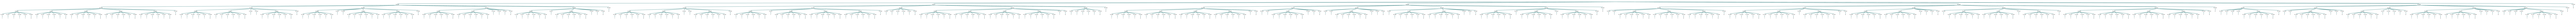

In [51]:
agent.plot_tree()

Now let's look at the evolution of the agent's accuracy during training.

In [52]:
accuracies_3 = []
iterations_3 = []
list_weights = sorted(os.listdir('q_learning_3/'), key = iteration)

In [53]:
for i, path in enumerate(list_weights):
    agent.load_weights('q_learning_3/' + path)
    agent.greedy_policy()
    accuracies_3.append(agent.test(env, n_test=1000))
    iterations_3.append(iteration(path))

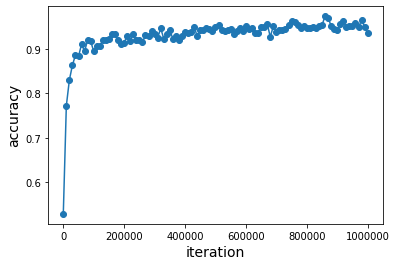

In [54]:
plt.plot(iterations_3, accuracies_3, 'o-')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
# plt.savefig('../fig/q_learning_3.png')
plt.show()

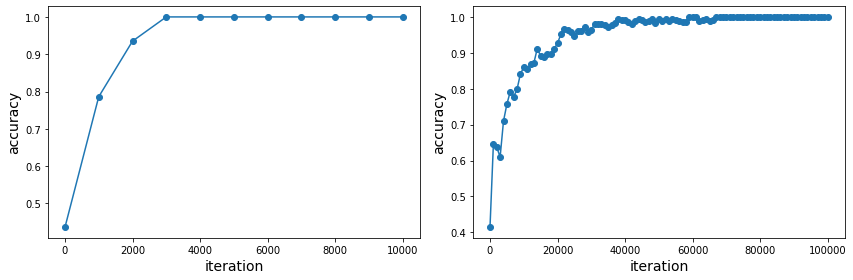

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(iterations, accuracies, '-o')
axs[0].set_xlabel('iteration', fontsize=14)
axs[0].set_ylabel('accuracy', fontsize=14)
axs[1].plot(iterations_2, accuracies_2, '-o')
axs[1].set_xlabel('iteration', fontsize=14)
axs[1].set_ylabel('accuracy', fontsize=14)
plt.tight_layout()
plt.savefig('../fig/q_learning_1_2.png')
plt.show()

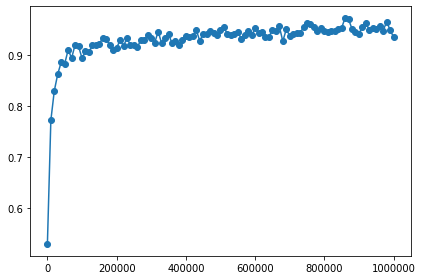

In [75]:
# plt.plot(iterations_3, accuracies_3, '-o')
# plt.tight_layout()
# plt.savefig('../fig/q_learning_3.png')

# Double DQN

## Experiment 4

Now we consider huge state spaces where Q-Learning is not feasible and approximations are needed. Consider the following setting:

- $d = 15$; $k_0 = 3, k_1 = 5, k_2 = 3, k_3 = 3, k_4 = 3, k_5 = 5, k_6 = 3, \\ k_7 = 5, k_8 = 3, k_9 = 3, k_{10} = 4, k_{11} = 3, k_{12} = 3, k_{13} = 3, k_{14} = 5$: $|\mathcal{X}| = 147622500$


We label data points with all feature values lower than or equal to $4$ as $1$, and $0$ if there exists a feature with value higher than $4$.

We train an architecture of two $32-$fully connected layers with ReLU activation function and an fully-connected output layer with number of units equal to the number of possible actions, which means here: $17$. We use a relatively high learning rate of $10^{-3}$ since we noticed the loss to be very stable during training.

In [28]:
categories = [3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5]
d = len(categories)
labels = [0, 1]
actions = range(d + len(labels))

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -.5) for i in range(len(categories))])

# Define the one-hot encoder.
encoder = Encoder(categories=categories)

In [29]:
env = EnvironmentSynthetic(generator, rewards_queries, encoder=encoder, r_plus=5, r_minus=-5, split=4)
agent = DQN(categories=categories)

Check if the classes are balanced on 10000 generated samples.

In [78]:
l = []
for i in range(10000):
    data_point, _ = env.generate()
    l.append(env.concept(data_point))

print('Fraction of 1 labeled points : %.5f' %(np.sum(l)/10000))

Fraction of 1 labeled points : 0.41460


Run training for 100000 episodes, you can check the evolution of the loss with command ``tensorboard --logdir runs/``. If it becomes constant for many episodes, one can assume that the gradient has hit a plateau and can thus stop training, the progress will not be lost, agent.q_network holds the current network parameters.

In [4]:
agent.train(env, n_episodes=100000, n_pretrain=512, n_learn=5, max_tau=50, decay_rate=3e-6, lr=1e-3, batch_size=256)

Episode : 0, epsilon : 1.000
Episode : 1000, epsilon : 0.956
Episode : 2000, epsilon : 0.914
Episode : 3000, epsilon : 0.874
Episode : 4000, epsilon : 0.835
Episode : 5000, epsilon : 0.799
Episode : 6000, epsilon : 0.763
Episode : 7000, epsilon : 0.730
Episode : 8000, epsilon : 0.698
Episode : 9000, epsilon : 0.667
Episode : 10000, epsilon : 0.638
Episode : 11000, epsilon : 0.610
Episode : 12000, epsilon : 0.583
Episode : 13000, epsilon : 0.557
Episode : 14000, epsilon : 0.533
Episode : 15000, epsilon : 0.509
Episode : 16000, epsilon : 0.487
Episode : 17000, epsilon : 0.465
Episode : 18000, epsilon : 0.445
Episode : 19000, epsilon : 0.425
Episode : 20000, epsilon : 0.407
Episode : 21000, epsilon : 0.389
Episode : 22000, epsilon : 0.372
Episode : 23000, epsilon : 0.355
Episode : 24000, epsilon : 0.340
Episode : 25000, epsilon : 0.325
Episode : 26000, epsilon : 0.310
Episode : 27000, epsilon : 0.297
Episode : 28000, epsilon : 0.284
Episode : 29000, epsilon : 0.271
Episode : 30000, epsilo

Save the models' weights.

In [13]:
# agent.save_weights('ddqn_weights.pth')

Load the models' weights.

In [6]:
agent.load_weights('dqn_weights/dqn_weights_99000.pth')

Now, let's test the agent on 10000 new generated points and evaluate its accuracy.

In [7]:
agent.test(env, 10000)

0.9954

We have $100\%$ accuracy descpite dealing with a huge state space. Now it would be interesting to visualize our agent's policy as a decision tree, we know that only feature variables $X_1, X_5, X_7, X_{14}$ are relevant to the decision process, despite the $100\%$, the agent might have used unnecessary features leading to a deeper decision tree than the optimal.

The tree plot is normally unclear, please double click on it to make it clear.

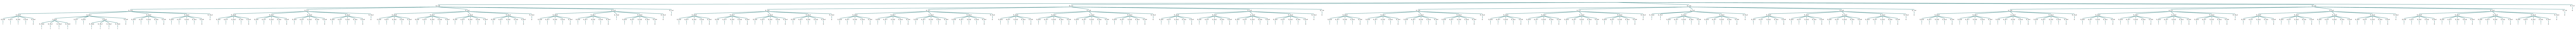

In [8]:
agent.plot_tree(encoder)

Indeed the agent only considers feature variables $X_1, X_5, X_7, X_{14}$ and converged to the optimal decision tree.

Let's now check the evolution of the agent's accuracy over the traning episodes. The models' weights were saved each $1000$ episodes for a total of $100000$ episodes.

In [30]:
accuracies_dqn = []
iterations_dqn = []
list_weights = sorted(os.listdir('dqn_weights/'), key = iteration)

In [31]:
for i, path in enumerate(list_weights):
    agent.load_weights('dqn_weights/' + path)
    accuracies_dqn.append(agent.test(env, n_test=1000))
    iterations_dqn.append(iteration(path))
    if i%10 == 0: print('testing model : %d' %i)

testing model : 0
testing model : 10
testing model : 20
testing model : 30
testing model : 40
testing model : 50
testing model : 60
testing model : 70
testing model : 80
testing model : 90


There is some instability in the agent's performance during training. It is clear that a uniform sampling strategy from the replay buffer is not ideal, instead we could make use of a prioritized experience replay where transitions are weighted according to some interest metric (usually the temporal difference) in order to be sampled. This method might stabilize and make training faster.

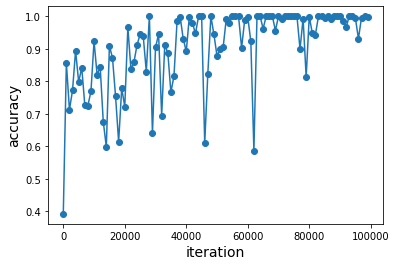

In [33]:
plt.plot(iterations_dqn, accuracies_dqn, 'o-')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
# plt.savefig('../fig/dqn.png')
plt.show()

# Advantage Actor-Critic

We use the same experimental setup as in DQN with the same input space and concept.

The Actor and Critic share the parameters of two $32-$fully-connected layers with ReLU activation, then the Actor uses a linear output layer of dimension $17$ while the Critic uses a uni-dimensional linear output.

In this setup, the episode length is at most $16$ which is relatively short, so we can wait for the episode to finish and use the gathered rewards to make the parameters updates which is equivalent to using REINFORCE with a baseline.

## Experiment 5

In [34]:
categories = [3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5]
labels = [0, 1]
d, b = len(categories), len(labels)
actions = range(d + len(labels))

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -.5) for i in range(len(categories))])

# Define ethe encoder
encoder = Encoder(categories=categories)

### Minimum number of queries: 2

First, we impose a minimum number of queries equal to $2$ to expose the fact that the agent takes a report action as soon as it is allowed, and that this behaviour hinders its performance.

In [35]:
env = EnvironmentSynthetic(generator, rewards_queries, encoder=encoder, r_plus=5, r_minus=-10, split=4)
agent = ActorCritic(categories=categories, min_queries=2)

Please uncomment the next cell if you would like to run a training. Otherwise you can load the models' weigths in the cell after.

In [17]:
agent.train(env, n_episodes=100000, lr=3e-4, lambd=1, max_step=30, log_dir='runs_ac_min_queries_2/', path_save='ac_weights_min_queries_2/')

Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Episode : 7000
Episode : 8000
Episode : 9000
Episode : 10000
Episode : 11000
Episode : 12000
Episode : 13000
Episode : 14000
Episode : 15000
Episode : 16000
Episode : 17000
Episode : 18000
Episode : 19000
Episode : 20000
Episode : 21000
Episode : 22000
Episode : 23000
Episode : 24000
Episode : 25000
Episode : 26000
Episode : 27000
Episode : 28000
Episode : 29000
Episode : 30000
Episode : 31000
Episode : 32000
Episode : 33000
Episode : 34000
Episode : 35000
Episode : 36000
Episode : 37000
Episode : 38000
Episode : 39000
Episode : 40000
Episode : 41000
Episode : 42000
Episode : 43000
Episode : 44000
Episode : 45000
Episode : 46000
Episode : 47000
Episode : 48000
Episode : 49000
Episode : 50000
Episode : 51000
Episode : 52000
Episode : 53000
Episode : 54000
Episode : 55000
Episode : 56000
Episode : 57000
Episode : 58000
Episode : 59000
Episode : 60000
Episode : 61000
Episode : 62000
Episo

In [21]:
# agent.load_weights('reinforce_min_queries_2.pth')
agent.load_weights('ac_weights_min_queries_2/actor_critic_weights_99000.pth')

Let's check the accuracy of the model on $10000$ new generated data points after training for 100000 episodes.

In [22]:
agent.test(env, 10000)

0.7749

We get an accuracy of $76\%$ which is not that good. Notice in the agent's decision tree below that it takes a report action as soon as it is allowed, but on the positive side, the agent actually used feature variables $X_1$ and $X_5$ which are among the relevant features to our labeling concept. Let's remind that the relevant features in our setting are $X_1, X_5, X_7, X_{14}$

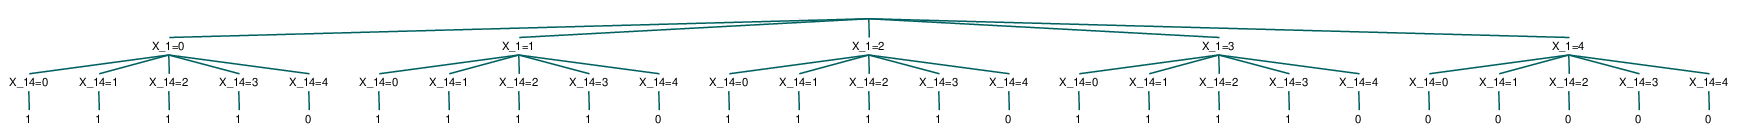

In [23]:
agent.plot_tree(encoder)

### Minimum number of queries: 3

Now let's set the minimum number of queries to $3$ and see if it makes the agent learn a better decision tree.

In [24]:
env = EnvironmentSynthetic(generator, rewards_queries, encoder=encoder, r_plus=5, r_minus=-10, split=4)
agent = ActorCritic(categories=categories, min_queries=3)

Please uncomment the next cell if you would like to run a training. Otherwise you can load the models' weigths in the cell after.

In [25]:
agent.train(env, n_episodes=100000, lr=3e-4, lambd=1, max_step=30, log_dir='runs_ac_min_queries_3/', path_save='ac_weights_min_queries_3/')

Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Episode : 7000
Episode : 8000
Episode : 9000
Episode : 10000
Episode : 11000
Episode : 12000
Episode : 13000
Episode : 14000
Episode : 15000
Episode : 16000
Episode : 17000
Episode : 18000
Episode : 19000
Episode : 20000
Episode : 21000
Episode : 22000
Episode : 23000
Episode : 24000
Episode : 25000
Episode : 26000
Episode : 27000
Episode : 28000
Episode : 29000
Episode : 30000
Episode : 31000
Episode : 32000
Episode : 33000
Episode : 34000
Episode : 35000
Episode : 36000
Episode : 37000
Episode : 38000
Episode : 39000
Episode : 40000
Episode : 41000
Episode : 42000
Episode : 43000
Episode : 44000
Episode : 45000
Episode : 46000
Episode : 47000
Episode : 48000
Episode : 49000
Episode : 50000
Episode : 51000
Episode : 52000
Episode : 53000
Episode : 54000
Episode : 55000
Episode : 56000
Episode : 57000
Episode : 58000
Episode : 59000
Episode : 60000
Episode : 61000
Episode : 62000
Episo

In [29]:
agent.load_weights('ac_weights_min_queries_3/actor_critic_weights_99000.pth')

Let's check the accuracy of the model on $10000$ new generated data points after training for 100000 episodes.

In [30]:
agent.test(env, 10000)

0.8992

We have a much better accuracy than previously, $89\%$. Notice in the agent's decision tree below that the agent used only the relevant features $X_1, X_7, X_{14}$, but it still performed a report action as soon as it was possible.

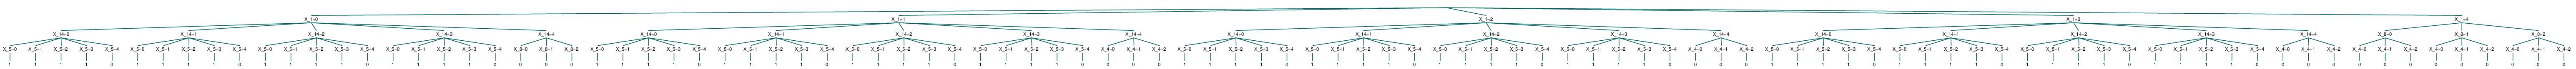

In [31]:
agent.plot_tree(encoder)

### Minimum number of queries: 4

Here we set the minimum number of queries to $4$, which is actually the number of relevant features. Since the agent has been able previously to select only the relevant features to build its decision tree but was limited by a small minimum number of queries, we expect it to be able to use all the relevant features in this experiment and thus perform very well.

In [32]:
env = EnvironmentSynthetic(generator, rewards_queries, encoder=encoder, r_plus=5, r_minus=-10, split=4)
agent = ActorCritic(categories=categories, min_queries=4)

Please uncomment the next cell if you would like to run a training. Otherwise you can load the models' weigths in the cell after.

In [33]:
agent.train(env, n_episodes=100000, lr=3e-4, lambd=1, max_step=30, log_dir='runs_ac_min_queries_4/', path_save='ac_weights_min_queries_4/')

Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Episode : 7000
Episode : 8000
Episode : 9000
Episode : 10000
Episode : 11000
Episode : 12000
Episode : 13000
Episode : 14000
Episode : 15000
Episode : 16000
Episode : 17000
Episode : 18000
Episode : 19000
Episode : 20000
Episode : 21000
Episode : 22000
Episode : 23000
Episode : 24000
Episode : 25000
Episode : 26000
Episode : 27000
Episode : 28000
Episode : 29000
Episode : 30000
Episode : 31000
Episode : 32000
Episode : 33000
Episode : 34000
Episode : 35000
Episode : 36000
Episode : 37000
Episode : 38000
Episode : 39000
Episode : 40000
Episode : 41000
Episode : 42000
Episode : 43000
Episode : 44000
Episode : 45000
Episode : 46000
Episode : 47000
Episode : 48000
Episode : 49000
Episode : 50000
Episode : 51000
Episode : 52000
Episode : 53000
Episode : 54000
Episode : 55000
Episode : 56000
Episode : 57000
Episode : 58000
Episode : 59000
Episode : 60000
Episode : 61000
Episode : 62000
Episo

In [18]:
agent.load_weights('actor_critic_weights_min_queries_4/actor_critic_weights_99000.pth')

Let's check the accuracy of the model on $10000$ new generated data points after training for 100000 episodes.

In [34]:
agent.test(env, 10000)

1.0

Indeed, in this experiment, the agent gets a perfect accuracy of $100\%$ and has its decision tree below converging to the optimal one.

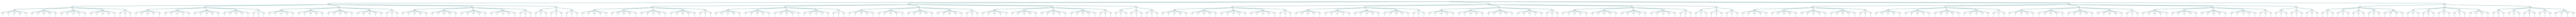

In [35]:
agent.plot_tree(encoder)

Let's now check the evolution of the agent's accuracy over the traning episodes. The models' weights were saved each $1000$ episodes for a total of $100000$ episodes.

In [36]:
accuracies_min_queries_2 = []
accuracies_min_queries_3 = []
accuracies_min_queries_4 = []

iterations = []
list_weights = sorted(os.listdir('ac_weights_min_queries_2/'), key = iteration)

In [37]:
for i, path in enumerate(list_weights):
    agent = ActorCritic(categories=categories, min_queries=2)
    agent.load_weights('ac_weights_min_queries_2/' + path)
    accuracies_min_queries_2.append(agent.test(env, n_test=1000))
    
    agent = ActorCritic(categories=categories, min_queries=3)
    agent.load_weights('ac_weights_min_queries_3/' + path)
    accuracies_min_queries_3.append(agent.test(env, n_test=1000))
    
    agent = ActorCritic(categories=categories, min_queries=4)
    agent.load_weights('ac_weights_min_queries_4/' + path)
    accuracies_min_queries_4.append(agent.test(env, n_test=1000))
    
    iterations.append(iteration(path))
    if i%10 == 0: print('testing model : %d' %i)

testing model : 0
testing model : 10
testing model : 20
testing model : 30
testing model : 40
testing model : 50
testing model : 60
testing model : 70
testing model : 80
testing model : 90


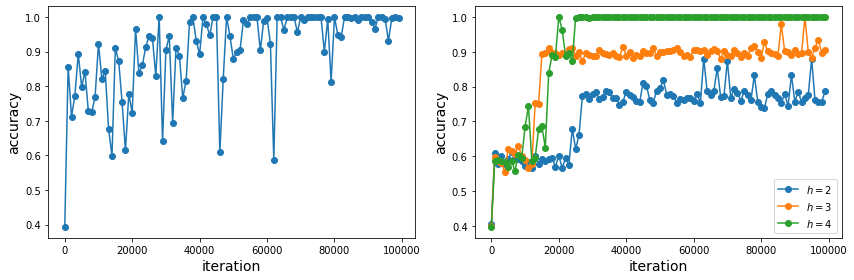

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(iterations, accuracies_dqn, 'o-', label='dqn')
axs[0].set_xlabel('iteration', fontsize=14)
axs[0].set_ylabel('accuracy', fontsize=14)
axs[1].plot(iterations, accuracies_min_queries_2, 'o-', label=r'$h=2$')
axs[1].plot(iterations, accuracies_min_queries_3, 'o-', label=r'$h=3$')
axs[1].plot(iterations, accuracies_min_queries_4, 'o-', label=r'$h=4$')
axs[1].set_xlabel('iteration', fontsize=14)
axs[1].set_ylabel('accuracy', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('../fig/dqn_ac_compared.png')
plt.show()

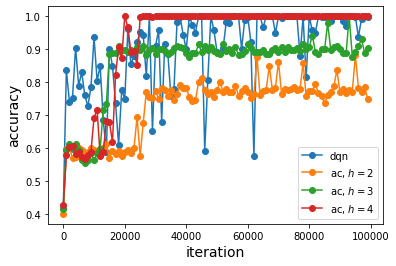

In [14]:
plt.plot(iterations, accuracies_dqn, 'o-', label='dqn')
plt.plot(iterations, accuracies_min_queries_2, 'o-', label=r'ac, $h=2$')
plt.plot(iterations, accuracies_min_queries_3, 'o-', label=r'ac, $h=3$')
plt.plot(iterations, accuracies_min_queries_4, 'o-', label=r'ac, $h=4$')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend()
# plt.savefig('../fig/actor_critic_weights.png')
plt.show()

## Experiment 6

Since Advantage Actor-Critic has been very successful when the minimum number of queries was well tuned (basically equal to the number of relevant features in our previous experiment), we would like to put this method to the test with a far bigger state space.

- $d = 20$; $k_0 = 10, k_1 = 8, k_2 = 5, k_3 = 6, k_4 = 5, k_5 = 7, k_6 = 10, \\ k_7 = 10, k_8 = 10, k_9 = 4, k_{10} = 8, k_{11} = 9, k_{12} = 5, k_{13} = 7, \\ k_{14} = 10, k_{15} = 6, k_{16} = 2, k_{17} = 3, k_{18} = 2, k_{19} = 8$: $|\mathcal{X}| = 4877107200000000$

We label data points with all feature values lower than or equal to $9$ as $1$, and $0$ if there exists a feature with value higher than $9$. So the relevant features in this setting are $X_0, X_6, X_7, X_8, X_{14}$

We use the same network architecture as previously in the experiment.

In [23]:
categories = [10, 8, 5, 6, 5, 7, 10, 10, 10, 4, 8, 9, 5, 7, 10, 6, 2, 3, 2, 8]
d = len(categories)
labels = [0, 1]
actions = range(d + len(labels))

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -.5) for i in range(len(categories))])

encoder = Encoder(categories=categories)

In [24]:
env = EnvironmentDQN(generator, rewards_queries, encoder, r_plus=5, r_minus=-10, split=9)
agent = AgentActorCritic(categories=categories, min_queries=5)

Please uncomment the next cell if you would like to run a training. Otherwise you can load the models' weigths in the cell after.

In [10]:
# agent.train(env, n_train=100000, lr=3e-4, lambd=1, max_step=30, log_dir='runs_new_exp/', path_save='actor_critic_weights_new_exp/')

Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Episode : 7000
Episode : 8000
Episode : 9000
Episode : 10000
Episode : 11000
Episode : 12000
Episode : 13000
Episode : 14000
Episode : 15000
Episode : 16000
Episode : 17000
Episode : 18000
Episode : 19000
Episode : 20000
Episode : 21000
Episode : 22000
Episode : 23000
Episode : 24000
Episode : 25000
Episode : 26000
Episode : 27000
Episode : 28000
Episode : 29000
Episode : 30000
Episode : 31000
Episode : 32000
Episode : 33000
Episode : 34000
Episode : 35000
Episode : 36000
Episode : 37000
Episode : 38000
Episode : 39000
Episode : 40000
Episode : 41000
Episode : 42000
Episode : 43000
Episode : 44000
Episode : 45000
Episode : 46000
Episode : 47000
Episode : 48000
Episode : 49000
Episode : 50000
Episode : 51000
Episode : 52000
Episode : 53000
Episode : 54000
Episode : 55000
Episode : 56000
Episode : 57000
Episode : 58000
Episode : 59000
Episode : 60000
Episode : 61000
Episode : 62000
Episo

In [25]:
agent.load_weights('actor_critic_weights_new_exp/actor_critic_weights_99000.pth')

Let's check the accuracy of the model on $10000$ new generated data points after training for 100000 episodes.

In [26]:
agent.test(env, 10000)

0.9964

The agent has been very successful with a $100\%$ test accuracy in this experiment too. So tuning the minimum number of queries hyperparameter in a real world problem with Advantage Actor-Critic can be very helpful. Actually, this hyperparameter has been use in the RLDT paper, and we see it to be similar to setting the depth of the decision tree in a classic decision tree building algorithm like CART.

Unfortunately, due to the huge size of the decision tree in this setting, we cannot visualize it since tree traversal will take a lot of time.

Let's now check the evolution of the agent's accuracy over the traning episodes. The models' weights were saved each $1000$ episodes for a total of $100000$ episodes.

In [27]:
accuracies = []
iterations = []
iteration = lambda s : int(re.split('_', s[:-4])[-1])
list_weights = sorted(os.listdir('actor_critic_weights_new_exp/'), key = iteration)

In [28]:
for i, path in enumerate(list_weights):
    agent.load_weights('actor_critic_weights_new_exp/' + path)
    accuracies.append(agent.test(env, n_test=1000))
    iterations.append(iteration(path))
    if i%10 == 0: print('testing model : %d' %i)

testing model : 0
testing model : 10
testing model : 20
testing model : 30
testing model : 40
testing model : 50
testing model : 60
testing model : 70
testing model : 80
testing model : 90


Although fluctuating a little bit, we clearly notice a fast convergence of the agent and its test accuracy remained around $0.9-1$ for the remaining training episodes.

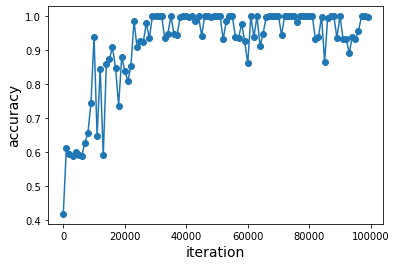

In [29]:
plt.plot(iterations, accuracies, 'o-')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.savefig('../fig/actor_critic_weights_new_exp.png')
plt.show()